In [10]:
pip install pint

The system of units are assumed to be Kpc, M_sun, and year for distance, mass, and time, respectively.

In [11]:
import numpy as np
from scipy.stats import truncnorm
import matplotlib.pyplot as plt
import pint
ureg = pint.UnitRegistry()

# Constants
ureg.define('solar_mass = 1.98847e30 * kilogram')
k_B = 1.380649e-23 *(ureg.J/ureg.K) # Boltzmann constant in J/K
k_B = k_B.to(ureg. solar_mass*ureg. kpc**2/( ureg.year**2*ureg.K)) #Boltzman constant in our desirable units

#generating the boundry size
#This size also depends on the phase of galaxy formation,
#but I tried to choose the aprroximate maximum possible size of a primordial galaxy formaing gas cloud
boundary_size = 100*ureg.kpc

#typical temperature in a primordial galaxy forming environment
#This can vary between 10K to 10^7K depending on the phase of galaxy formation
#Here we assume that we are still in the pre-collapse phase, so we have:
T = 10*ureg.K

#typical rotating speed in a primordial galaxy forming environment
velocity_typical = 100*(ureg.km/ureg.s)
velocity_typical = velocity_typical.to(ureg.kpc/ureg.year)

##Two Body Problem, 2D
In this case, it is very improbabile that any of these two particles go out of the boundries, so I leave this for the next part, which is the N-body problem.
For two particles that rotate around each other, the initial locations and velocities will be as followed:

In [12]:
N =2 #number of particles
M = np.ones ((N, 1)) ##generating the mass of particles,each particle has a mass equal to solar_mass
v = np.zeros((N, 3)) #velocity of each particle in xyz coordinates
xyz = np.zeros ((N, 3)) #location of each particle in xyz coordinates

In [13]:
 #Locations
#coordinates xyz[:, 0] -> x, xyz[:, 1] -> y, xyz[:, 2] -> z
# first particle
xyz[0, 0] = boundary_size.magnitude/2
xyz[0, 1] = 0
xyz[0, 2] = 0

#second particle
xyz[1, 0] = -boundary_size.magnitude/2
xyz[1, 1] = 0
xyz[1, 2] = 0


# v[:, 0] -> vx, v[:, 1] -> vy, v[:, 2] -> vz
#first particle
v[0, 0] = velocity_typical.magnitude #x
v[0, 1] = velocity_typical.magnitude #y
v[0, 2] = 0 #z

#second particle
v[1, 0] = -velocity_typical.magnitude #x
v[1, 1] = -velocity_typical.magnitude #y
v[1, 2] = 0 #z

#N Body Problem, 3D
In this case the boundries become important and we also need to define a distribution system for the initial locations and velocities.
I have decided to use a Maxwell_Boltzman distribution for velocities.

In [14]:
N =1000 #number of particles
M = np.ones ((N, 1)) ##generating the mass of particles, each particle has a mass equal to solar_mass
v = np.zeros((N, 3)) #velocity of each particle in xyz coordinates
xyz = np.zeros ((N, 3)) #location of each particle in xyz coordinates

In [15]:
# Velocity dispersion (standard deviation of the velocity components)
sigma_v = np.sqrt(k_B * T/ ureg.solar_mass)
sigma_v = sigma_v.to(ureg.kpc/ureg.year)

# Generate Maxwell-Boltzmann velocities for each particle
velocities = np.random.normal(0, sigma_v.magnitude, (N, 3))

## Generate the initial position for particles

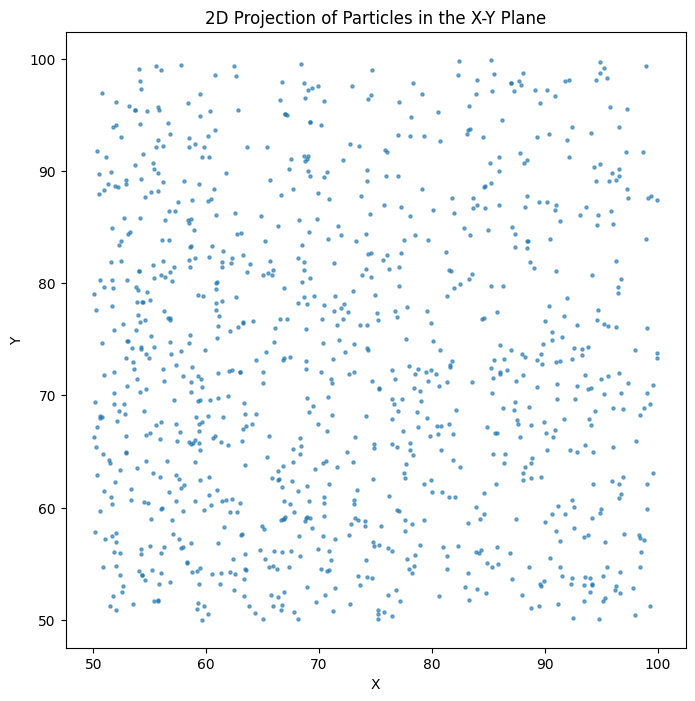

In [16]:
def position_ini(N, bound, mu, sigma):
  bound = bound.to('kpc').magnitude
  a = 0 # lower truncated bound
  b = (bound - mu) / sigma #upper truncated bound
  x = truncnorm.rvs(a,b, loc=mu, scale=sigma, size=N)
  y = truncnorm.rvs(a,b, loc=mu, scale=sigma, size=N)
  z = truncnorm.rvs(a,b, loc=mu, scale=sigma, size=N)
  pos = np.column_stack((x, y, z))
  return pos

positions = position_ini(N=1000, bound = boundary_size, mu = 50, sigma = 50)  #boundary_size = boundary_size.to('kpc').magnitude
positions = positions * ureg.kiloparsec

## make plot and check the initial position
plt.figure(figsize=(8, 8))
plt.scatter(positions[:, 0], positions[:, 1], alpha=0.6, s=5)
plt.xlabel("X")
plt.ylabel("Y")
plt.title("2D Projection of Particles in the X-Y Plane")
plt.show()



## Store the information in a class

In [17]:
class Particles:
    def __init__(self, position, velocity, mass):
        self.position = position
        self.velocity = velocity
        self.mass = mass
    def __getitem__(self, index):
        return {
            'position': self.position[index],
            'velocity': self.velocity[index],
            'mass': self.mass[index] if not np.isscalar(self.mass) else self.mass
        }

particles = Particles(positions, velocities, M)

print(particles[1]['position'])
print(particles[1]['velocity'])
print(particles[1]['mass'])

[99.55626292187347 70.88663481523194 88.57049650758374] kiloparsec
[ 1.43380233e-39 -5.14749044e-39  2.70997175e-39]
[1.]


##Defining the boundry conditions ("the box")

In [18]:
def boundary_cond(particles):
   #reverse if out-of-bound
    particles_in = [] #inside the boundary
    boundary_size = 100
    for particle in particles:
        pos_1 = particle.position.to('kpc').magnitude  #change the unit scale
        if np.all(np.abs(pos_1) < boundary_size / 2):
            particles_in.append(particle)
        else:
            particle.velocity *= -1

    particles = particles_in